# Introduction

In this notebook we'll attack the MedNIST data set presented in the previous notebook using a deep learning library called _fastai_. You may remember it from the lab on NLP. It can do images too..

**Note:** To run this notebook you have to have the fastai library installed. See https://docs.fast.ai for instructions. Beware that this is more complicated to install than the other libraries used in ELMED219, unless you have a suitable computer running GNU/Linux (Ubuntu or similar). 

You may decide to just read through the notebook, and perhaps pick it up again if you later dig into deep learning. 

# Setup

In [1]:
from fastai.vision.all import *

# Load data

In [2]:
path = untar_data("https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1", fname='MedNIST.tar.gz')

In [3]:
path.ls()

(#8) [Path('/home/ubuntu/.fastai/data/MedNIST.tar/HeadCT'),Path('/home/ubuntu/.fastai/data/MedNIST.tar/CXR'),Path('/home/ubuntu/.fastai/data/MedNIST.tar/models'),Path('/home/ubuntu/.fastai/data/MedNIST.tar/Hand'),Path('/home/ubuntu/.fastai/data/MedNIST.tar/AbdomenCT'),Path('/home/ubuntu/.fastai/data/MedNIST.tar/BreastMRI'),Path('/home/ubuntu/.fastai/data/MedNIST.tar/ChestCT'),Path('/home/ubuntu/.fastai/data/MedNIST.tar/README.md')]

In [4]:
fnames = get_image_files(path)
def label_func(x): return x.parent.name
dls = ImageDataLoaders.from_path_func(path, fnames, label_func, valid_pct=0.3)

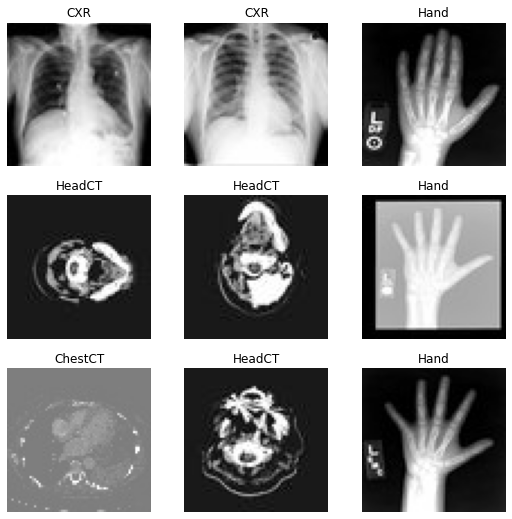

In [5]:
dls.show_batch()

In [6]:
print(f'Number of training images: {len(dls.train_ds)}')
print(f'Number of validation images: {len(dls.valid_ds)}')

Number of training images: 41268
Number of validation images: 17686


Here we create what fastai calls a _learner_. It's created from the above dataloaders and its neural network has a specific architecture (and is pretrained on a large 1.4 million image set from the ImageNet competition). Here we use a `resnet34`. 

In [7]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=accuracy)

Let's train it for a bit:

In [8]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.025279,0.011194,0.998078,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.001744,0.000021,1.000000,00:35


Essentially 100% accurate on the validation data after a minute of training.

We can have a look at some predictions:

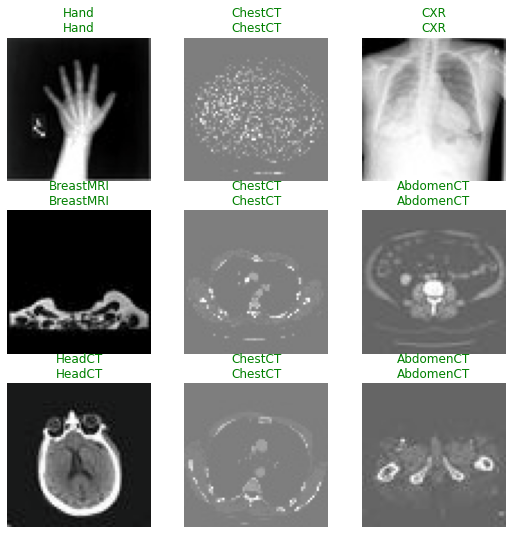

In [9]:
learn.show_results()

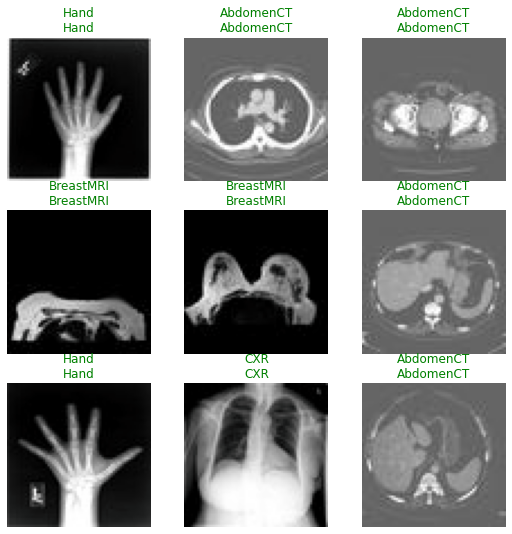

In [10]:
learn.show_results()

...and also the confusion matrix and the images it found most difficult

In [11]:
interp = ClassificationInterpretation.from_learner(learn)

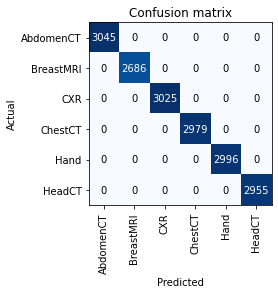

In [12]:
interp.plot_confusion_matrix()

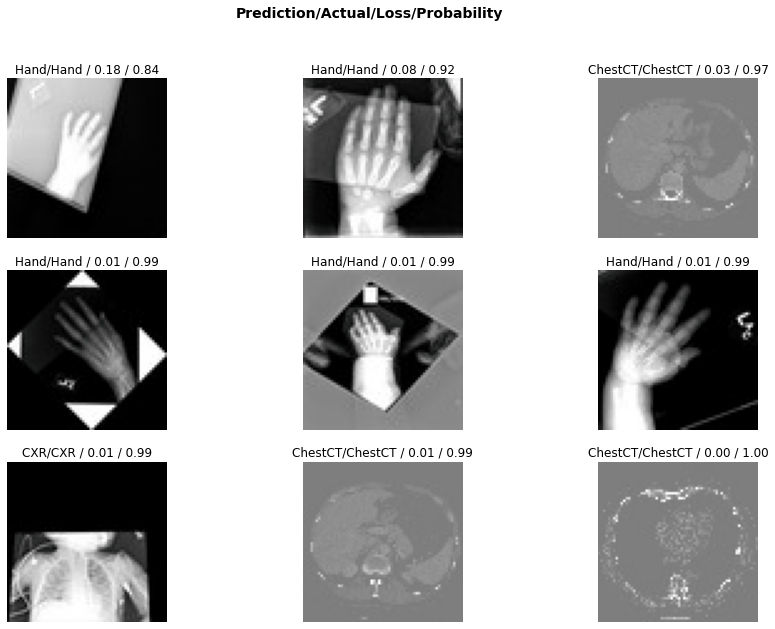

In [13]:
interp.plot_top_losses(9, figsize=(15,10))

We see that the problem is too simple when we're using such powerful methods as above. Let's try another!

# Another example

About the data (from https://stanfordmlgroup.github.io/competitions/mura):
> MURA (musculoskeletal radiographs) is a large dataset of bone X-rays. Algorithms are tasked with determining whether an X-ray study is normal or abnormal.

> Musculoskeletal conditions affect more than 1.7 billion people worldwide, and are the most common cause of severe, long-term pain and disability, with 30 million emergency department visits annually and increasing. We hope that our dataset can lead to significant advances in medical imaging technologies which can diagnose at the level of experts, towards improving healthcare access in parts of the world where access to skilled radiologists is limited.

> MURA is one of the largest public radiographic image datasets. We're making this dataset available to the community and hosting a competition to see if your models can perform as well as radiologists on the task.

In [14]:
MURA = Path('/data2/MURA/processed/')
train_df = pd.read_csv('MURA_train_images.csv')
val_df = pd.read_csv('MURA_val_images.csv')

We'll do some transoformations of the data as in the PyTorch notebook. The rotation and flips are examples of **data augmentation**. By randomly changing the images by rotation and left-right horisontal flips while keeping their labels one can in a sense create "extra" training data. And also make the trained model more robust for those transformations. 

In [15]:
transforms = [Normalize.from_stats(*imagenet_stats), Rotate(max_deg=10), FlipItem()]

In [16]:
dls = ImageDataLoaders.from_folder(MURA,valid='val',
                                  item_tfms=Resize(256), 
                                   batch_tfms=transforms)

Here are a few images from one batch (batch size is set to 64, these are 9 of them).

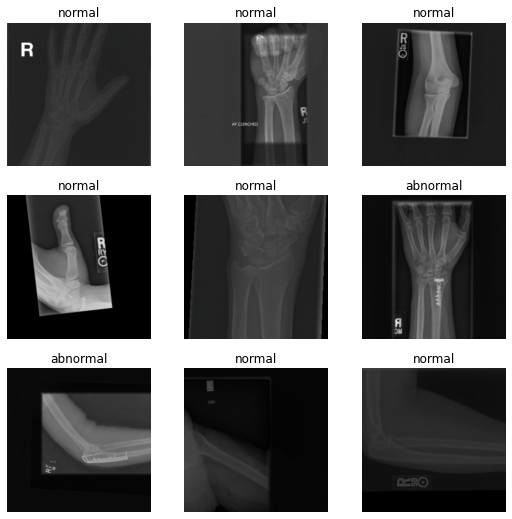

In [17]:
dls.show_batch()

In [18]:
print(f'Number of training images: {len(dls.train_ds)}')
print(f'Number of validation images: {len(dls.valid_ds)}')

Number of training images: 37111
Number of validation images: 3225


We can create a learner as above.

This time we use a larger, pretrained model as our starting point, the 169 layer DenseNet (see the lecture for a description).

In [19]:
kappa = CohenKappa()
learn = cnn_learner(dls, densenet169, metrics=[accuracy, kappa])

In [ ]:
learn.fine_tune(10, base_lr=0.004)
#learn.save(f'mura-model-trained-arch-densenet169')

This takes some time, so we'll rather load the results I got from running the above training ahead of time, which looked like this:

<img src="assets/dn169-training.png">

In [21]:
learn = learn.load(f'mura-model-trained-arch-densenet169')

## Evaluating the model

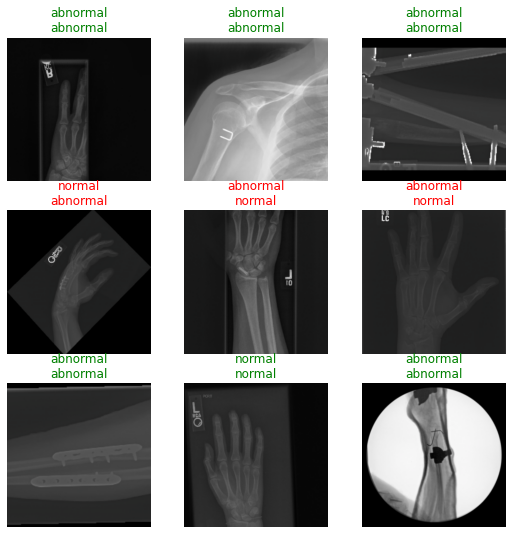

In [22]:
learn.show_results()

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

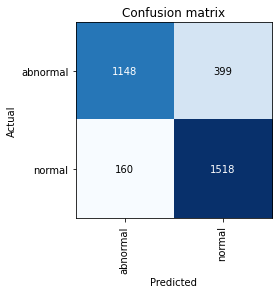

In [24]:
interp.plot_confusion_matrix()

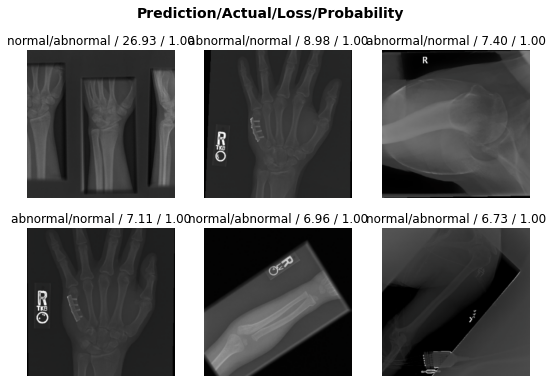

In [25]:
interp.plot_top_losses(6)

In [26]:
from fastai2_extensions.interpret.all import *

In [27]:
interp = ClassificationInterpretationEx.from_learner(learn)

/home/ubuntu/anaconda3/envs/fastai-dev/lib/python3.8/site-packages/fastai2_extensions/interpret/interpret.py:133: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.annotate(s  = f"{ht:.02f}",
/home/ubuntu/anaconda3/envs/fastai-dev/lib/python3.8/site-packages/fastai2_extensions/interpret/interpret.py:142: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation='vertical' if vertical_labels else 'horizontal')


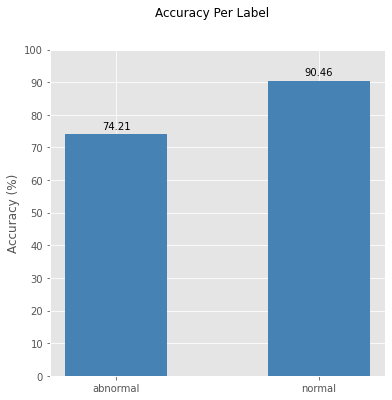

In [28]:
plt.style.use('ggplot')
interp.plot_accuracy()

## Study-level predictions

Note that it doesn't make great sense to use the labels assigned to studies as labels on the individual images in a study, as above. _A study can indicate an abnormality even if there are images in the studies with no findings._

By taking this into account one could easily design better models. 

However, keeping things simple, let's just make study-level predictions based on the above model's predictions on the images of a study. 

It makes sense to mark a study as 'abnormal' if at least one image in the study is predicted as 'abnormal'. That's achieved by the below function.

In [29]:
import ast
def predict_study(studyID):
    preds = []
    relevant = val_df.loc[val_df.patient == studyID]
    imgs = ast.literal_eval(relevant['study_imagefns'].values[0])
    for img in imgs:
        pred = learn.predict(img)[0]
        if pred=='abnormal':
            preds.append(1)
        else:
            preds.append(0)
    if sum(preds)>=1: return 1
    else: return 0

Here's our validation data set:

In [30]:
val_df.head()

,patient,kind,study_dx,study_imagefns
0,XR_ELBOW_patient11257_study1_positive,XR_ELBOW,1,"['/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11257_study1_positive_image3.png', '/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11257_study1_positive_image2.png', '/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11257_study1_positive_image1.png', '/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11257_study1_positive_image4.png', '/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11257_study1_positive_image5.png']"
1,XR_ELBOW_patient11260_study1_positive,XR_ELBOW,1,"['/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11260_study1_positive_image2.png', '/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11260_study1_positive_image4.png', '/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11260_study1_positive_image3.png', '/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11260_study1_positive_image1.png']"
2,XR_ELBOW_patient11275_study1_negative,XR_ELBOW,0,"['/data2/MURA/processed/val/normal/XR_ELBOW_patient11275_study1_negative_image1.png', '/data2/MURA/processed/val/normal/XR_ELBOW_patient11275_study1_negative_image2.png']"
3,XR_ELBOW_patient11276_study1_negative,XR_ELBOW,0,"['/data2/MURA/processed/val/normal/XR_ELBOW_patient11276_study1_negative_image2.png', '/data2/MURA/processed/val/normal/XR_ELBOW_patient11276_study1_negative_image1.png', '/data2/MURA/processed/val/normal/XR_ELBOW_patient11276_study1_negative_image3.png']"
4,XR_ELBOW_patient11288_study1_negative,XR_ELBOW,0,"['/data2/MURA/processed/val/normal/XR_ELBOW_patient11288_study1_negative_image1.png', '/data2/MURA/processed/val/normal/XR_ELBOW_patient11288_study1_negative_image2.png', '/data2/MURA/processed/val/normal/XR_ELBOW_patient11288_study1_negative_image3.png']"


We can run the above function on all the studies in the validation data set and insert the results in the above dataframe as follows:

In [ ]:
val_df['pred_dx'] = val_df.patient.apply(predict_study)

...then construct the confusion matrix and compute the accuracy and the Cohen Kappa score:

In [32]:
# The above computation takes a bit of time. We can rather load the precomputed results:
#val_df.to_csv('mura-val-dn-results.csv', index=None)
val_df = pd.read_csv('mura-val-dn-results.csv')

In [33]:
val_df.head()

,patient,kind,study_dx,study_imagefns,pred_dx
0,XR_ELBOW_patient11257_study1_positive,XR_ELBOW,1,"['/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11257_study1_positive_image3.png', '/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11257_study1_positive_image2.png', '/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11257_study1_positive_image1.png', '/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11257_study1_positive_image4.png', '/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11257_study1_positive_image5.png']",1
1,XR_ELBOW_patient11260_study1_positive,XR_ELBOW,1,"['/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11260_study1_positive_image2.png', '/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11260_study1_positive_image4.png', '/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11260_study1_positive_image3.png', '/data2/MURA/processed/val/abnormal/XR_ELBOW_patient11260_study1_positive_image1.png']",1
2,XR_ELBOW_patient11275_study1_negative,XR_ELBOW,0,"['/data2/MURA/processed/val/normal/XR_ELBOW_patient11275_study1_negative_image1.png', '/data2/MURA/processed/val/normal/XR_ELBOW_patient11275_study1_negative_image2.png']",0
3,XR_ELBOW_patient11276_study1_negative,XR_ELBOW,0,"['/data2/MURA/processed/val/normal/XR_ELBOW_patient11276_study1_negative_image2.png', '/data2/MURA/processed/val/normal/XR_ELBOW_patient11276_study1_negative_image1.png', '/data2/MURA/processed/val/normal/XR_ELBOW_patient11276_study1_negative_image3.png']",0
4,XR_ELBOW_patient11288_study1_negative,XR_ELBOW,0,"['/data2/MURA/processed/val/normal/XR_ELBOW_patient11288_study1_negative_image1.png', '/data2/MURA/processed/val/normal/XR_ELBOW_patient11288_study1_negative_image2.png', '/data2/MURA/processed/val/normal/XR_ELBOW_patient11288_study1_negative_image3.png']",1


**Confusion matrix:**

In [34]:
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix

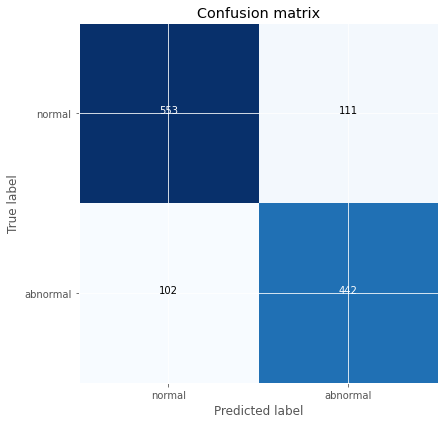

In [35]:
classes=['normal', 'abnormal']
cm = confusion_matrix(val_df.study_dx, val_df.pred_dx)
fig, ax = plt.subplots(figsize=(12,6))
_ = plot_confusion_matrix(cm, classes=classes, ax=ax)

**Metrics:**

In [36]:
from sklearn.metrics import accuracy_score, cohen_kappa_score

In [37]:
accuracy_score(val_df.study_dx, val_df.pred_dx)

0.8236754966887417

In [38]:
cohen_kappa_score(val_df.study_dx, val_df.pred_dx)

0.6443680270679684

### Is this a good result?

Again, that depends on what we want to achieve...

An indication can be had by comparing it to other models on the MURA competition leaderboard:

https://stanfordmlgroup.github.io/competitions/mura/

Not too bad for something that could be constucted this easily.